In [1]:
from qiskit import *

In [13]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import QFT, PhaseGate, XGate
import numpy as np
from math import pi

def qft_rotations(circuit, n, n_max):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1

    circuit.h(n)
    for qubit in range(n-1, n):
        if qubit >= 0:
            circuit.cp(pi/2**(n-qubit), qubit, n)
    if n == n_max - 1:
        circuit.p(pi/2**(n_max-2), n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n, n_max)
    return circuit

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n, n_max, do_swaps=False):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n, n_max)
    if do_swaps:
        swap_registers(circuit, n)
    return circuit

def draper_adder(n_bits, a, controlado=False, div=False, control_number=1):
    """Retorna um circuito que corresponde ao DraperQFTAdder [1], sem as QFTs e com um operando clássicamente calculado.

    Faz a operação a + b : b é o número que está no registrador reg_b.

    Parametros:
    n_bits : int
        Número de bits do operando.
    a : int
        Operando implícito calculado classicamente.
    controlado : bool
        Se o adder será controlado ou não (precisa do bit de controle).
    div : bool
        Se o adder será utilizado em uma divisão.
    control_number : int
        Número de qubits que controlam esse operador (c qubits).

    Retorna:
    QuantumCircuit 
    circuito montado com os registradores nessa ordem:
        if controlado: 
            c + n + 1 qubits
            registrador_controle (c bits)
            registrador_operando (n bits)
            registrador_carryout (1 bit)
        else:
            n + 1 qubits
            registrador_operando (n bits)
            registrador_carryout (1 bit)

    References: 
        [1] T. G. Draper, Addition on a Quantum Computer, 2000. arXiv:quant-ph/0008033
        https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.DraperQFTAdder
    """

    # Registradores principais
    reg_b = QuantumRegister(n_bits, "b")
    reg_cout = QuantumRegister(1, "cout")

    if div: # Se for divisão, *2 até ficar com n_bits
        bitstring = bin(a)[2:] + ("0" * (n_bits - len(bin(a)) + 2))
    else: # Se não for divisão, igualar o numero de bits sem alterar o valor
        bitstring = bin(a)[2:].zfill(n_bits)
    bitstring = bitstring[::-1]

    if not controlado:
        qc = QuantumCircuit(reg_b, reg_cout, name="adapt_drap_adder")
        l = [0]*(n_bits)
        cout = [0]
        for j in range(n_bits):
            for k in range(n_bits - j):
                if bitstring[j] == "1":
                    lam = np.pi / (2**k)
                    l[j + k] += lam

        for j in range(n_bits):
            if bitstring[n_bits - j - 1] == "1":
                lam = np.pi / (2 ** (j + 1))
                cout[0] += lam

        for i in range(len(l)):
            if l[i] != 0:
                qc.p(l[i], reg_b[i])

        for i in range(len(cout)):
            if cout[i] != 0:
                qc.p(cout[0], reg_cout[0])

        # print(l)

    else:
        # Registrador de controle
        reg_c = QuantumRegister(control_number, "c")

        qc = QuantumCircuit(reg_c, reg_b, reg_cout, name="c_adapt_drap_adder")

        l = [0]*(n_bits)
        cout = [0]

        # Portas controladas por A e pelo registrador de controle
        for j in range(n_bits):
            for k in range(n_bits - j):
                if bitstring[j] == "1":
                    lam = np.pi / (2**k)
                    l[j + k] += lam

        for i in range(len(l)):
            if l[i] != 0:            
                qc.append(PhaseGate(l[i]).control(control_number), reg_c[:] + reg_b[i:i + 1])

        for j in range(n_bits):
            if bitstring[n_bits - j - 1] == "1":
                lam = np.pi / (2 ** (j + 1))
                cout[0] += lam
        
        for i in range(len(cout)):
            if cout[i] != 0:
                qc.append(PhaseGate(cout[i]).control(control_number), reg_c[:] + reg_cout[:])

    return qc


def adder_mod(n_bits, a, N, controlado=False, control_number=1):
    """Retorna um circuito que implementa o Adder Modular proposto no artigo [1]
        usando o DraperQFTAdder com 1 operando clássicamente calculado como Adder e aplicando
        otimizações do artigo [2] quanto as QFTs.

    Faz a operação a + b mod N : b é o número que está no registrador reg_b.

    Exemplo: Adder Modular controlado, com um operando de 4 qubits. 

      ┌─────────────────────┐┌────────────────────────┐                                             ┌────────────────────────┐                                ┌─────────────────────┐
   c: ┤0                    ├┤0                       ├─────────────────────────────────────────────┤0                       ├────────────────■───────────────┤0                    ├
      │                     ││                        │┌───────┐     ┌──────┐┌─────────────────────┐│                        │┌───────┐       │       ┌──────┐│                     │
 b_0: ┤1                    ├┤1                       ├┤0      ├─────┤0     ├┤1                    ├┤1                       ├┤0      ├───────┼───────┤0     ├┤1                    ├
      │                     ││                        ││       │     │      ││                     ││                        ││       │       │       │      ││                     │
 b_1: ┤2                    ├┤2                       ├┤1      ├─────┤1     ├┤2                    ├┤2                       ├┤1      ├───────┼───────┤1     ├┤2                    ├
      │  c_adapt_drap_adder ││  c_adapt_drap_adder_dg ││       │     │      ││                     ││  c_adapt_drap_adder_dg ││       │       │       │      ││  c_adapt_drap_adder │
 b_2: ┤3                    ├┤3                       ├┤2 IQFT ├─────┤2 QFT ├┤3                    ├┤3                       ├┤2 IQFT ├───────┼───────┤2 QFT ├┤3                    ├
      │                     ││                        ││       │     │      ││  c_adapt_drap_adder ││                        ││       │       │       │      ││                     │
 b_3: ┤4                    ├┤4                       ├┤3      ├─────┤3     ├┤4                    ├┤4                       ├┤3      ├───────┼───────┤3     ├┤4                    ├
      │                     ││                        ││       │     │      ││                     ││                        ││       │┌───┐  │  ┌───┐│      ││                     │
cout: ┤5                    ├┤5                       ├┤4      ├──■──┤4     ├┤5                    ├┤5                       ├┤4      ├┤ X ├──■──┤ X ├┤4     ├┤5                    ├
      └─────────────────────┘└────────────────────────┘└───────┘┌─┴─┐└──────┘│                     │└────────────────────────┘└───────┘└───┘┌─┴─┐└───┘└──────┘└─────────────────────┘
 anc: ──────────────────────────────────────────────────────────┤ X ├────────┤0                    ├────────────────────────────────────────┤ X ├────────────────────────────────────
                                                                └───┘        └─────────────────────┘                                        └───┘

    Parametros:
    n_bits : int
        Número de bits do operando.
    a : int
        Operando implícito calculado classicamente.
    N : int
        Operando implícito que controla o mod
    controlado : bool
        Se o adder será controlado ou não (precisa do bit de controle).
    control_number : int
        Número de qubits que controlam esse operador (c qubits).

    Retorna:
    QuantumCircuit 
    circuito montado com os registradores nessa ordem:
        if controlado: 
            c + n + 2 qubits
            registrador_controle (c bits)
            registrador_operando (n bits)
            registrador_carryout (1 bit)
            registrador_ancilla (1 bit)
        else:
            n + 2 qubits
            registrador_operando (n bits)
            registrador_carryout (1 bit)
            registrador_ancilla (1 bit)

    References: 
        [1] Vlatko Vedral, Adriano Barenco, and Artur Ekert, Quantum networks for elementary arithmetic operations, quant-ph/9511018
        [2] Stephane Beauregard, Circuit for Shor's algorithm using 2n+3 qubits, arXiv:quant-ph/0205095
    """

    # Construção dos registradores

    if controlado:
        reg_control = QuantumRegister(control_number, "c")

    reg_b = QuantumRegister(n_bits, "b")
        
    reg_cout = QuantumRegister(1, "cout")

    reg_anc = QuantumRegister(1, "anc")

    if controlado:
        if control_number == 1:
            # Construção do circuito
            qc = QuantumCircuit(reg_control, reg_b, reg_cout, reg_anc, name="c_adder_mod") 
        
            qc.append(draper_adder(n_bits, a, controlado=True), reg_control[:] + reg_b[:] + reg_cout[:])

            qc.append(draper_adder(n_bits, N, controlado=True).inverse(), reg_control[:] + reg_b[:] + reg_cout[:])

            qc.append(QFT(n_bits + 1, do_swaps=False).inverse(), reg_b[:] + reg_cout[:])

            qc.cx(reg_cout[0], reg_anc[0])

            qc.append(QFT(n_bits + 1, do_swaps=False), reg_b[:] + reg_cout[:])

            qc.append(draper_adder(n_bits, N, controlado=True), reg_anc[:] + reg_b[:] + reg_cout[:])
        
            qc.append(draper_adder(n_bits, a, controlado=True).inverse(), reg_control[:] + reg_b[:] + reg_cout[:])

            qc.append(QFT(n_bits + 1, do_swaps=False).inverse(), reg_b[:] + reg_cout[:])

            qc.x(reg_cout)
            qc.ccx(reg_control[0], reg_cout[0], reg_anc[0])
            qc.x(reg_cout)

            qc.append(QFT(n_bits + 1, do_swaps=False), reg_b[:] + reg_cout[:])

            qc.append(draper_adder(n_bits, a, controlado=True), reg_control[:] + reg_b[:] + reg_cout[:])
        elif control_number == 2:
            qc = QuantumCircuit(reg_control, reg_b, reg_cout, reg_anc, name="c_adder_mod") 

            qft_simplificada = QuantumCircuit(n_bits + 1)
            qft(qft_simplificada, n_bits + 1, n_bits + 1)
        
            qc.append(draper_adder(n_bits, a, controlado=True, control_number=control_number), reg_control[:] + reg_b[:] + reg_cout[:])

            qc.append(draper_adder(n_bits, N, controlado=True, control_number=control_number).inverse(), reg_control[:] + reg_b[:] + reg_cout[:])

            qc.append(QFT(n_bits + 1, do_swaps=False).inverse(), reg_b[:] + reg_cout[:])
            #qc.append(qft_simplificada.inverse(), reg_b[:] + reg_cout[:])

            qc.cx(reg_cout[0], reg_anc[0])

            qc.append(QFT(n_bits + 1, do_swaps=False), reg_b[:] + reg_cout[:])
            #qc.append(qft_simplificada, reg_b[:] + reg_cout[:])

            qc.append(draper_adder(n_bits, N, controlado=True), reg_anc[:] + reg_b[:] + reg_cout[:])
        
            qc.append(draper_adder(n_bits, a, controlado=True, control_number=control_number).inverse(), reg_control[:] + reg_b[:] + reg_cout[:])

            qc.append(QFT(n_bits + 1, do_swaps=False).inverse(), reg_b[:] + reg_cout[:])
            #qc.append(qft_simplificada.inverse(), reg_b[:] + reg_cout[:])

            qc.x(reg_cout)
            qc.append(XGate().control(control_number+1), reg_control[:] + reg_cout[:] + reg_anc[:])
            qc.x(reg_cout)

            qc.append(QFT(n_bits + 1, do_swaps=False), reg_b[:] + reg_cout[:])
            #qc.append(qft_simplificada, reg_b[:] + reg_cout[:])

            qc.append(draper_adder(n_bits, a, controlado=True, control_number=control_number), reg_control[:] + reg_b[:] + reg_cout[:])


    else:
        qc = QuantumCircuit(reg_b, reg_cout, reg_anc, name="adder_mod")

        qc.append(draper_adder(n_bits, a), reg_b[:] + reg_cout[:])

        qc.append(draper_adder(n_bits, N).inverse(), reg_b[:] + reg_cout[:])

        qc.append(QFT(n_bits + 1, do_swaps=False).inverse(), reg_b[:] + reg_cout[:])

        qc.cx(reg_cout[0], reg_anc[0])

        qc.append(QFT(n_bits + 1, do_swaps=False).inverse(), reg_b[:] + reg_cout[:])

        qc.append(draper_adder(n_bits, N, controlado=True), reg_anc[:] + reg_b[:] + reg_cout[:])
    
        qc.append(draper_adder(n_bits, a).inverse(), reg_b[:] + reg_cout[:])

        qc.append(QFT(n_bits + 1, do_swaps=False).inverse(), reg_b[:] + reg_cout[:])

        qc.cx(reg_cout[0], reg_anc[0], ctrl_state="0")

        qc.append(QFT(n_bits + 1, do_swaps=False).inverse(), reg_b[:] + reg_cout[:])

        qc.append(draper_adder(n_bits, a), reg_b[:] + reg_cout[:])

    return qc

'''
def draper_adder(n_bits, a, controlado=False, kind="half", control_number=1, div=False):
    """Retorna um circuito que corresponde ao DraperQFTAdder [1], sem as QFTs e com um operando clássicamente calculado.

    Faz a operação a + b : b é o número que está no registrador reg_b.

    Parametros:
    n_bits : int
        Número de bits do operando.
    a : int
        Operando implícito calculado classicamente.
    kind : string
        Diz o tipo do Adder, "half" é o default e adiciona um CarryOut, "fixed" não adiciona CarryOut
        e por isso a adição é feita módulo 2^n_bits
    controlado : bool
        Se o adder será controlado ou não (precisa do bit de controle).
    control_number : int
        Número de qubits que controlam esse operador (c qubits).
    div : bool
        Se o adder será utilizado em uma divisão.

    Retorna:
    QuantumCircuit 
    circuito montado com os registradores nessa ordem:
        if controlado: 
            c + n + 1 qubits
            registrador_controle (c bits)
            registrador_operando (n bits)
            registrador_carryout (1 bit)
        else:
            n + 1 qubits
            registrador_operando (n bits)
            registrador_carryout (1 bit)

    References: 
        [1] T. G. Draper, Addition on a Quantum Computer, 2000. arXiv:quant-ph/0008033
        https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.DraperQFTAdder
    """

    # Registradores principais
    reg_b = QuantumRegister(n_bits, "b")
    if kind=="half":
        reg_cout = QuantumRegister(1, "cout")

    if div: # Se for divisão, *2 até ficar com n_bits
        bitstring = bin(a)[2:] + ("0" * (n_bits - len(bin(a)) + 2))
    else: # Se não for divisão, igualar o numero de bits sem alterar o valor
        bitstring = bin(a)[2:].zfill(n_bits)
    bitstring = bitstring[::-1]

    if not controlado:
        if kind=="half":
            qc = QuantumCircuit(reg_b, reg_cout, name="adapt_drap_adder")
        else: 
            qc = QuantumCircuit(reg_b, name="adapt_drap_adder")

        # Portas controladas por A
        for j in range(n_bits):
            for k in range(n_bits - j):
                if bitstring[j] == "1":
                    lam = np.pi / (2**k)
                    qc.p(lam, reg_b[j + k])

        if kind=="half":
            for j in range(n_bits):
                if bitstring[n_bits - j - 1] == "1":
                    lam = np.pi / (2 ** (j + 1))
                    qc.p(lam, reg_cout[0])

    else:
        # Registrador de controle
        reg_c = QuantumRegister(control_number, "c")
        if kind=="half":
            qc = QuantumCircuit(reg_c, reg_b, reg_cout, name="c_adapt_drap_adder")
        else:
            qc = QuantumCircuit(reg_c, reg_b, name="c_adapt_drap_adder")

        # Portas controladas por A e pelo registrador de controle
        for j in range(n_bits):
            for k in range(n_bits - j):
                if bitstring[j] == "1":
                    lam = np.pi / (2**k)
                    qc.append(PhaseGate(lam).control(control_number), reg_c[:] + reg_b[j + k:j + k + 1])

        if kind=="half":
            for j in range(n_bits):
                if bitstring[n_bits - j - 1] == "1":
                    lam = np.pi / (2 ** (j + 1))
                    qc.append(PhaseGate(lam).control(control_number), reg_c[:] + reg_cout[:])

    return qc


def adder_mod(n_bits, a, N, controlado=False, control_number=1):
    """Retorna um circuito que implementa o Adder Modular proposto no artigo [1]
        usando o DraperQFTAdder com 1 operando clássicamente calculado como Adder e aplicando
        otimizações do artigo [2] quanto as QFTs.

    Faz a operação a + b mod N : b é o número que está no registrador reg_b.

    Exemplo: Adder Modular controlado, com um operando de 4 qubits. 

      ┌─────────────────────┐┌────────────────────────┐                                             ┌────────────────────────┐                                ┌─────────────────────┐
   c: ┤0                    ├┤0                       ├─────────────────────────────────────────────┤0                       ├────────────────■───────────────┤0                    ├
      │                     ││                        │┌───────┐     ┌──────┐┌─────────────────────┐│                        │┌───────┐       │       ┌──────┐│                     │
 b_0: ┤1                    ├┤1                       ├┤0      ├─────┤0     ├┤1                    ├┤1                       ├┤0      ├───────┼───────┤0     ├┤1                    ├
      │                     ││                        ││       │     │      ││                     ││                        ││       │       │       │      ││                     │
 b_1: ┤2                    ├┤2                       ├┤1      ├─────┤1     ├┤2                    ├┤2                       ├┤1      ├───────┼───────┤1     ├┤2                    ├
      │  c_adapt_drap_adder ││  c_adapt_drap_adder_dg ││       │     │      ││                     ││  c_adapt_drap_adder_dg ││       │       │       │      ││  c_adapt_drap_adder │
 b_2: ┤3                    ├┤3                       ├┤2 IQFT ├─────┤2 QFT ├┤3                    ├┤3                       ├┤2 IQFT ├───────┼───────┤2 QFT ├┤3                    ├
      │                     ││                        ││       │     │      ││  c_adapt_drap_adder ││                        ││       │       │       │      ││                     │
 b_3: ┤4                    ├┤4                       ├┤3      ├─────┤3     ├┤4                    ├┤4                       ├┤3      ├───────┼───────┤3     ├┤4                    ├
      │                     ││                        ││       │     │      ││                     ││                        ││       │┌───┐  │  ┌───┐│      ││                     │
cout: ┤5                    ├┤5                       ├┤4      ├──■──┤4     ├┤5                    ├┤5                       ├┤4      ├┤ X ├──■──┤ X ├┤4     ├┤5                    ├
      └─────────────────────┘└────────────────────────┘└───────┘┌─┴─┐└──────┘│                     │└────────────────────────┘└───────┘└───┘┌─┴─┐└───┘└──────┘└─────────────────────┘
 anc: ──────────────────────────────────────────────────────────┤ X ├────────┤0                    ├────────────────────────────────────────┤ X ├────────────────────────────────────
                                                                └───┘        └─────────────────────┘                                        └───┘

    Parametros:
    n_bits : int
        Número de bits do operando.
    a : int
        Operando implícito calculado classicamente.
    N : int
        Operando implícito que controla o mod
    controlado : bool
        Se o adder será controlado ou não (precisa do bit de controle).
    control_number : int
        Número de qubits que controlam esse operador (c qubits).

    Retorna:
    QuantumCircuit 
    circuito montado com os registradores nessa ordem:
        if controlado: 
            c + n + 2 qubits
            registrador_controle (c bits)
            registrador_operando (n bits)
            registrador_carryout (1 bit)
            registrador_ancilla (1 bit)
        else:
            n + 2 qubits
            registrador_operando (n bits)
            registrador_carryout (1 bit)
            registrador_ancilla (1 bit)

    References: 
        [1] Vlatko Vedral, Adriano Barenco, and Artur Ekert, Quantum networks for elementary arithmetic operations, quant-ph/9511018
        [2] Stephane Beauregard, Circuit for Shor's algorithm using 2n+3 qubits, arXiv:quant-ph/0205095
        [3] Takahashi, Yasuhiro and Kunihiro, Noboru, A quantum circuit for shor's factoring algorithm using 2n + 2 qubits, https://dl.acm.org/doi/abs/10.5555/2011665.2011669
    """

    # Construção dos registradores

    if controlado:
        reg_control = QuantumRegister(control_number, "c")

    reg_b = QuantumRegister(n_bits, "b")

    reg_anc = QuantumRegister(1, "anc")

    if controlado:
            qc = QuantumCircuit(reg_control, reg_b, reg_anc, name="c_adder_mod") 

            qc.append(draper_adder(n_bits, N - a, controlado=True, kind="fixed", control_number=control_number).inverse(), reg_control[:] + reg_b[:])

            qc.append(QFT(n_bits, do_swaps=False).inverse(), reg_b[:])

            qc.cx(reg_b[-1], reg_anc[0])

            qc.append(QFT(n_bits, do_swaps=False), reg_b[:])

            qc.append(draper_adder(n_bits, N, controlado=True, kind="fixed"), reg_anc[:] + reg_b[:])
        
            qc.append(draper_adder(n_bits, a, controlado=True, kind="fixed", control_number=control_number).inverse(), reg_control[:] + reg_b[:])

            qc.append(QFT(n_bits, do_swaps=False).inverse(), reg_b[:])

            qc.x(reg_b[-1])
            qc.append(XGate().control(control_number+1), reg_control[:] + reg_b[-1:] + reg_anc[:])
            qc.x(reg_b[-1])

            qc.append(QFT(n_bits, do_swaps=False), reg_b[:])

            qc.append(draper_adder(n_bits, a, controlado=True, kind="fixed", control_number=control_number), reg_control[:] + reg_b[:])
        
    else:
        qc = QuantumCircuit(reg_b, reg_anc, name="adder_mod")

        qc.append(draper_adder(n_bits, N - a, kind="fixed").inverse(), reg_b[:])

        qc.append(QFT(n_bits, do_swaps=False).inverse(), reg_b[:])

        qc.cx(reg_b[-1], reg_anc[0])

        qc.append(QFT(n_bits, do_swaps=False).inverse(), reg_b[:])

        qc.append(draper_adder(n_bits, N, controlado=True, kind="fixed"), reg_anc[:] + reg_b[:])
    
        qc.append(draper_adder(n_bits, a, kind="fixed").inverse(), reg_b[:])

        qc.append(QFT(n_bits, do_swaps=False).inverse(), reg_b[:])

        qc.cx(reg_b[-1], reg_anc[0], ctrl_state="0")

        qc.append(QFT(n_bits, do_swaps=False).inverse(), reg_b[:])

        qc.append(draper_adder(n_bits, a, kind="fixed"), reg_b[:])

    return qc
'''

'\ndef draper_adder(n_bits, a, controlado=False, kind="half", control_number=1, div=False):\n    """Retorna um circuito que corresponde ao DraperQFTAdder [1], sem as QFTs e com um operando clássicamente calculado.\n\n    Faz a operação a + b : b é o número que está no registrador reg_b.\n\n    Parametros:\n    n_bits : int\n        Número de bits do operando.\n    a : int\n        Operando implícito calculado classicamente.\n    kind : string\n        Diz o tipo do Adder, "half" é o default e adiciona um CarryOut, "fixed" não adiciona CarryOut\n        e por isso a adição é feita módulo 2^n_bits\n    controlado : bool\n        Se o adder será controlado ou não (precisa do bit de controle).\n    control_number : int\n        Número de qubits que controlam esse operador (c qubits).\n    div : bool\n        Se o adder será utilizado em uma divisão.\n\n    Retorna:\n    QuantumCircuit \n    circuito montado com os registradores nessa ordem:\n        if controlado: \n            c + n + 1 q

In [12]:
def prepare_x_state(num_pad_qubits: int) -> QuantumCircuit:
    reg_x = QuantumRegister(num_pad_qubits, name="reg_x")
    quantum_circuit = QuantumCircuit(reg_x)
    quantum_circuit.h(reg_x)
    return quantum_circuit

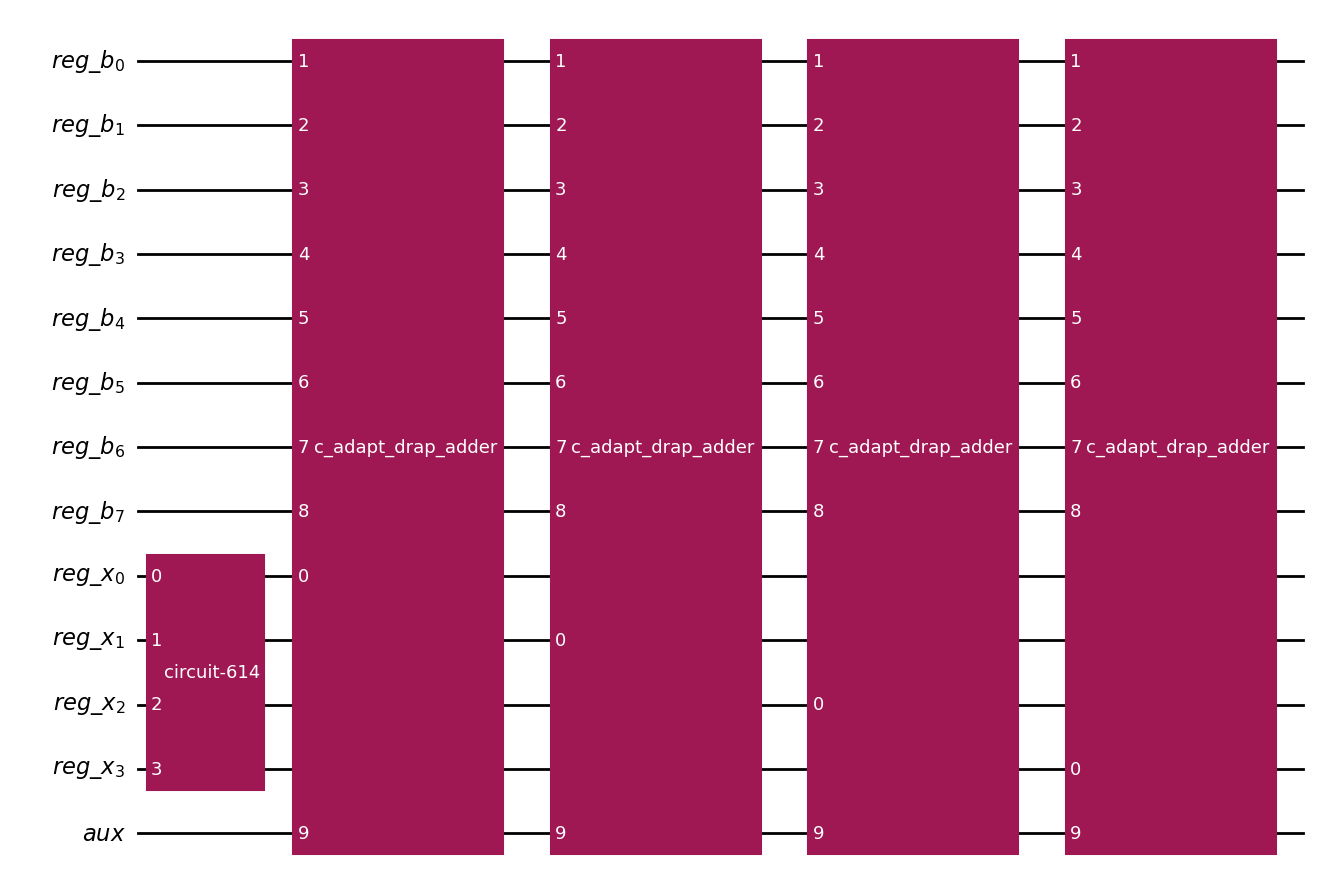

In [20]:
def convert_to_coset(num_op_qubits: int, num_pad_qubits: int, N: int) -> QuantumCircuit:
    reg_b = QuantumRegister(num_op_qubits+num_pad_qubits, name="reg_b")
    reg_x = QuantumRegister(num_pad_qubits, name="reg_x")
    reg_aux = QuantumRegister(1, name="aux")
    quantum_circuit = QuantumCircuit(reg_b, reg_x, reg_aux)
    quantum_circuit.append(prepare_x_state(num_pad_qubits), reg_x[:])
    for i in range(num_pad_qubits):
        quantum_circuit.append(draper_adder(num_op_qubits+num_pad_qubits, (2**i)*N, False,).control(1), reg_x[i:i+1] + reg_b[:] + reg_aux[:])
    return quantum_circuit

convert_to_coset(4,4,15).draw("mpl")